# Decision Tree

## I. Importation des librairies

In [1]:
import csv
import numpy as np
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from usefulCmdsAndFcns import get_metrics, plot_confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pyplot as plt

## II. Lecture descripteurs
Lecture du fichier contenant les descripteurs

In [3]:
# extraction des informations du csv
with open('../../predict/model/output.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))
data = np.array(data)

label_names = data[:,1024]
unique_label = np.unique(label_names)
feature_values = data[:, :1024]

## III. Modèle Decision Tree

In [7]:
# split données
X_train, X_test, y_train, y_test = train_test_split(feature_values, label_names, test_size=0.33, random_state=43)

# Decision Tree Classifier: entrainement de l'IA
DecisionTreeClassifier_ml = make_pipeline(preprocessing.StandardScaler(), DecisionTreeClassifier())
DecisionTreeClassifier_ml.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

## IV. Evaluation du modèle

Confusion matrix, without normalization
[[11  1  4  2  2  3  6  0  2  0]
 [ 1 22  3  1  0  1  0  0  1  1]
 [ 5  1  7  1  3  5  2  2  3  4]
 [ 2  0  4 11  9  0  8  3  2 11]
 [ 2  0  3  7  9  1  1  4  6  2]
 [ 0  4  4  2  0 14  1  2  3  1]
 [ 0  0  1  4  3  1 19  0  1  4]
 [ 0  0  1  6  3  0  0 15  1  1]
 [ 2  1  2  7  3  4  1  1  9  3]
 [ 3  0  3  2  0  0  3  0  5 11]]
Accuracy: 0.3879
Precision: 0.3873
Recall: 0.3879
F1 Score: 0.3855
Scores Decision Tree:  0.32727272727272727


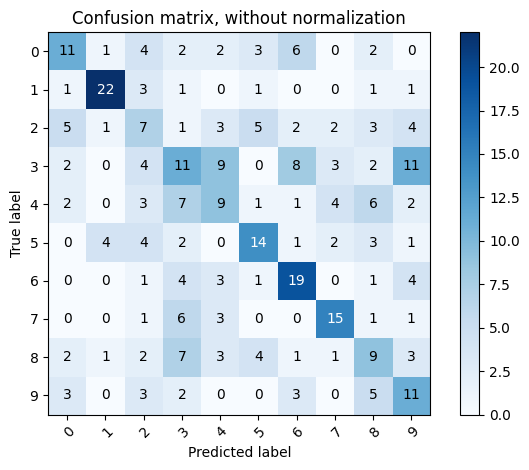

In [8]:
# evaluation du modele
plot_confusion_matrix(y_test,DecisionTreeClassifier_ml.predict(X_test))
get_metrics(y_test,DecisionTreeClassifier_ml.predict(X_test))
scores = cross_val_score(DecisionTreeClassifier_ml, X_test, y_test)
print("Scores Decision Tree: ",scores.mean())
plt.show()

## IV. Enregistrement du modèle

Enregistrement de la normalisation

In [9]:
# open the file in the write mode
with open('../../predict/model/model_DecisionTreeClassifier_ml.csv', 'w', encoding='UTF8') as f:
    # create the csv writer
    writer = csv.writer(f)
    # write a row to the csv file
    writer.writerow(DecisionTreeClassifier_ml['standardscaler'].scale_)
    writer.writerow(DecisionTreeClassifier_ml['standardscaler'].mean_)

Pour enregistrer le modèle, il faut descendre dans l'arbre. Nous avons donc implémenté une fonction récursive pour descendre dans l'arbre jusqu'à arriver au feuille lorsque les deux enfants de l'arbre sont identique c'est-à-dire qu'il n'y a pas d'enfant et qu'on est au plus bas de l'arbre.

In [10]:
def lecture_node(i):
    '''
    fonction permettant de parcourir l'arbre de décision de manière récursif et écrivant le code cpp permettant la décision
    prend en entrée le node i courant traité
    sort le texte correspondant au morceau de code de ses enfants
    '''
    clf = DecisionTreeClassifier_ml['decisiontreeclassifier']
    if(clf.tree_.children_left[i] == clf.tree_.children_right[i]):
        # condition d'arret : le node est une feuille de l'arbre
        return "cout << \"" + unique_label[np.argmax(clf.tree_.value[i])] + "\" << endl; return " + str(np.argmax(clf.tree_.value[i])) + ";"
    else:
        # sinon on traite les enfants
        txt_1 = lecture_node(clf.tree_.children_left[i])
        txt_2 = lecture_node(clf.tree_.children_right[i])
        if(clf.tree_.feature[i] <512):
            feature = "mu["+str(clf.tree_.feature[i]) + "]"
        else:
            feature = "sigma[" + str(clf.tree_.feature[i]-512) + "]"
        Text_1 = "if("+ feature + " <= " + str(clf.tree_.threshold[i]) + "){" + txt_1 + "}"
        Text_2 = "else{" + txt_2 + "}"
        return Text_1 + Text_2

Génération du code cpp

In [11]:
txt = ""
txt += "#include <iostream>  \n"
txt += "#include \"codeDecisionTree.h\" \n"
txt += "using namespace std; \n \n"
# fonction de decision arbre
txt += "int decision_tree(double mu[], double sigma[]){ \n"
txt += lecture_node(0)
txt += "}"

# écriture du code dans le fichier
fichier = open("../../predict/src/codeDecisionTree.cpp", "w")
fichier.write(txt)
fichier.close()

## ecriture du h
txt = "#ifndef CODE_DECISION_TREE__H \n #define CODE_DECISION_TREE_H \nint decision_tree(double mu[], double sigma[]);\n#endif"
fichier = open("../../predict/src/codeDecisionTree.h", "w")
fichier.write(txt)
fichier.close()